In [3]:
import os
import configuration
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import behavioural_analysis_functions as beh_func
from pathlib import Path
import pickle
import csv
import math
import os
import pandas as pd

In [4]:
cmaps = ['Greys', 'Reds', 'Purples', 'Blues', 'Greens', 'Oranges', 'PuBu', 'YlOrRd']
bodyparts = ["nose", "head","ear1","ear2","body"]

In [15]:
## select mouse and session to analyze 
mouse = 32363
session =1

In [16]:
## object positions directory
current_directory = os.environ['PROJECT_DIR'] + 'data/scoring_sheets/'
if mouse == 32363 or mouse == 32364 or mouse == 32365 or mouse == 32366:
    mice_directory = '32363-32366/'
else:
    mice_directory = '56165-56166/'

In [17]:
## source extracted calcium traces directory
calcium_directory = os.environ['PROJECT_DIR'] + 'data/calcium_activity_day_wise/'
## timeline directory
timeline_file_dir = os.environ['PROJECT_DIR'] + 'data/timeline/'
## behaviour directory
behaviour_path = os.environ['DATA_DIR_LOCAL'] + 'compiled_positions/'+f'{mouse}'+'/session_'+ f'{session}'+'/'
## output directoy
category_path = os.environ['DATA_DIR_LOCAL'] + 'ethogram_unsupervised/'+f'{mouse}'+'/session_'+ f'{session}'+'/'

In [18]:
## initial file that conteins mouse, session, trial, resting, and timestramp information.
# This table conteins all mice info
objects_file_name = current_directory + mice_directory + 'mouse_training_OS_calcium_1.xlsx'
objects_list_structure = ['condition', 'goal','group','session','drug','subject', 'trial','day', 'loc_1','loc_2']
object_list = pd.read_excel(objects_file_name)
object_list = pd.DataFrame(object_list,columns=objects_list_structure)
current_object_data = object_list[ object_list.subject ==mouse]
current_object_data = current_object_data[current_object_data.session == session]
objects = ['LR', 'LL', 'UR', 'UL']

In [19]:
## define trials for each day
timeline_length=[10,10,10,10,2]
session_trial = []
session_trial.append(np.arange(1,6))
session_trial.append(np.arange(6,11))
session_trial.append(np.arange(11,16))
session_trial.append(np.arange(16,21))
session_trial.append(np.arange(21,22))

In [20]:
def objects_position(current_object_data = None):
    ## load objects positions for this trial
    object1 = current_object_data.iloc[session_trial[day][trial]-1]['loc_1']
    object2 = current_object_data.iloc[session_trial[day][trial]-1]['loc_2']
    ## define coordinates of objects in pixels acording to the frame size
    if object1 == 'LL':
        coordinates1 = np.array([550,100])
        #exploratory_flag1 = 3
        #looking_flag1 = 7
    if object1 == 'LR':
        coordinates1 = np.array([150,100])
        #exploratory_flag1 = 4
        #looking_flag1 = 8
    if object1 == 'UR':
        coordinates1 = np.array([150,500])
        #exploratory_flag1 = 5
        #looking_flag1 = 9
    if object1 == 'UL':
        coordinates1 = np.array([550,500])
        #exploratory_flag1 = 6
        #looking_flag1 = 10
    if object2 == 'LL':
        coordinates2 = np.array([550,100])
        #exploratory_flag2 = 3
        #looking_flag2 = 7
    if object2 == 'LR':
        coordinates2 = np.array([150,100])
        #exploratory_flag2 = 4
        #looking_flag2 = 8
    if object2 == 'UR':
        coordinates2 = np.array([150,500])
        #exploratory_flag2 = 5
        #looking_flag2 = 9
    if object2 == 'UL':
        coordinates2 = np.array([550,500])
        #exploratory_flag2 = 6
        #looking_flag2 = 10

    return [coordinates1, coordinates2]

In [21]:
def head_direction(pos):
    # get head direction coordinates
    x_diff = pos[1,0] - pos[0,0]
    y_diff = pos[1,1] - pos[0,1]
    hd = np.array([x_diff , y_diff])
    hd = hd / np.sqrt(x_diff*x_diff + y_diff*y_diff)
    return hd

def body_direction(pos):
    # get body direction coordinates
    x_diff = pos[0,2] - pos[0,1]
    y_diff = pos[1,2] - pos[1,1]
    bd = np.array([x_diff , y_diff])
    #bd = bd / npalg.norm(bd)
    return bd

def distance(point1,point2):
    xdiff = point1[0] - point2[0]
    ydiff = point1[1] - point2[1]
    dist = np.sqrt(xdiff*xdiff + ydiff*ydiff)
    return dist

In [22]:
def get_parameters(tracking,coordinates1,coordinates2):
    
    positions_list = [beh_func.interpolate_positions(signal1 = tracking[:,i*2].T, signal2= tracking[:,i*2+1].T) for i in range(int(tracking.shape[1]/2))]
    positions = np.array(positions_list)
    
    cm =  np.mean(positions,axis=0)
    d1 = [distance(cm[:,i],coordinates1) for i in range(cm.shape[1])]
    d2 = [distance(cm[:,i],coordinates2) for i in range(cm.shape[1])]
    d1 = np.array(d1)
    d2 = np.array(d2)
    
    vx = np.zeros((cm.shape[1], 1))
    vy = np.zeros((cm.shape[1], 1))
    vx[1:, 0] = np.diff(cm[0, :])
    vy[1:, 0] = np.diff(cm[1, :])
    speed = np.squeeze(np.sqrt(vx * vx + vy * vy))
    
    hd_list = [head_direction(positions[:,:,i]) for i in range(positions.shape[2])]
    hd = np.array(hd_list)
    
    parameters = {'cm' : cm , 'head_direction': hd , 'speed' : speed, 'dist_obj1': d1 , 'dist_obj2':d2}

    return parameters

In [23]:
from sklearn.cluster import KMeans
day = 0
for trial_day in [1,6,11,16]:

    ## load calcium activity
    file_name = 'mouse_'+f'{mouse}'+'_session_'+f'{session}'+'_trial_'+f'{trial_day}' +'_v1.4.20.3.0.1.1.0.npy'
    activity = np.load(calcium_directory + file_name)

    ## load timeline
    timeline_file_path = timeline_file_dir + 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{1}' + '.4.' + f'{1}' + \
                          '.' + f'{0}' + '_10.pkl'
    timeline_file= open(timeline_file_path,'rb')
    timeline_info = pickle.load(timeline_file)

    timeline = np.zeros(timeline_length[day]+1)
    for i in range(timeline_length[day]):
        timeline[i] = timeline_info[i][1]
    timeline[len(timeline)-1] = activity.shape[1]
    trial_duration = np.diff(timeline)

    ## create vector to save behaviour
    ethogram_vector = np.zeros((activity.shape[1],1))
    ethogram_vector_ID = np.zeros((activity.shape[1],1))

    ## load tracking of behaviour
    for trial in range(len(session_trial[day])):
  
        [coordinates1,coordinates2] = objects_position(current_object_data)

        beh_file_name = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_' + \
                        f'{session_trial[day][trial]}' + '_likelihood_0.75.npy'
        beh_path = behaviour_path + beh_file_name
        if not os.path.isfile(beh_path):
            print('ERROR: Behaviour file not found:' + beh_path)
        else:
            tracking = np.load(beh_path)

            init_trial = int(timeline[trial*2])
            end_trial = int(timeline[trial*2+1])
            duration = np.min((tracking.shape[0],end_trial-init_trial))
                    
            parameters = get_parameters(tracking,coordinates1,coordinates2)
            parameters_matrix = np.zeros((7,parameters['cm'].shape[1]))                           
            parameters_matrix[0,:] = parameters['cm'][0,:]
            parameters_matrix[1,:] = parameters['cm'][1,:]
            parameters_matrix[2,:] = parameters['head_direction'][:,0]
            parameters_matrix[3,:] = parameters['head_direction'][:,1]
            parameters_matrix[4,:] = parameters['dist_obj1']
            parameters_matrix[5,:] = parameters['dist_obj2']
            parameters_matrix[6,:] = parameters['speed']
            
            kmeans = KMeans(n_clusters=10, random_state=0).fit(parameters_matrix.T)
            ethogram_classification = kmeans.labels_
            ethogram_vector[init_trial : init_trial + kmeans.labels_.shape[0],0] = ethogram_classification[:]
            
    output_tracking_file = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + \
                        f'{day+1}' + '_likelihood_0.75_unsupervised_ethogram.npy'
    output_tracking_path = category_path + output_tracking_file
    np.save(output_tracking_path,ethogram_vector)
    day = day +1


In [ ]:
day =1
unsupervised_path = os.environ['DATA_DIR_LOCAL'] + 'ethogram_unsupervised/'+f'{mouse}'+'/session_'+ f'{session}'+'/'
supervised_path = os.environ['DATA_DIR_LOCAL'] + 'ethogram/'+f'{mouse}'+'/session_'+ f'{session}'+'/'

ethogram_file = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + \
                        f'{day+1}' + '_likelihood_0.75_ethogram.npy'
ethogram_unsupervised_file = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + \
                        f'{day+1}' + '_likelihood_0.75_unsupervised_ethogram.npy'

etho1 = np.load(supervised_path + ethogram_file)
etho2 = np.load(unsupervised_path + ethogram_unsupervised_file)



In [65]:
## create a video with cathegory labels

import cv2

input_video_path_dlc = os.environ['DATA_DIR_LOCAL'] + 'videos/Trial1_11072017_2017-07-11-153223-0000.avi'
output_video_path = os.environ['DATA_DIR_LOCAL'] + 'ethogram_videos/Trial1_11072017_2017-07-11-153223-0000_unsupervised.avi'
font = cv2.FONT_HERSHEY_SIMPLEX

if not os.path.isfile(input_video_path_dlc):
    print('ERROR: File not found')
cap_dlc = cv2.VideoCapture(input_video_path_dlc)
try:
    length = int(cap_dlc.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap_dlc.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_dlc.get(cv2.CAP_PROP_FRAME_HEIGHT))
except:
    #logging.info('Roll back to opencv 2')
    length = int(cap_dlc.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
    width = int(cap_dlc.get(cv2.cv.CV_CAP_PROP_FRAME_WIDTH))
    height = int(cap_dlc.get(cv2.cv.CV_CAP_PROP_FRAME_HEIGHT))
if length == 0 or width == 0 or height == 0:  # CV failed to load
    cv_failed = True
    
dims_dlc = [length, height, width]
limits = False
ret, frame = cap_dlc.read()

day = 1
trial_day = 1
## load tracking of behaviour
trial = 0
[coordinates1,coordinates2] = objects_position(current_object_data)
beh_file_name = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_' + \
                f'{session_trial[day][trial]}' + '_likelihood_0.75.npy'
beh_path = behaviour_path + beh_file_name
if not os.path.isfile(beh_path):
    print('ERROR: Behaviour file not found:' + beh_path)
else:
    tracking = np.load(beh_path)
    parameters = get_parameters(tracking,coordinates1,coordinates2)
    parameters_matrix = np.zeros((7,parameters['cm'].shape[1]))
    parameters_matrix[0,:] = parameters['cm'][0,:]
    parameters_matrix[1,:] = parameters['cm'][1,:]
    parameters_matrix[2,:] = parameters['head_direction'][:,0]
    parameters_matrix[3,:] = parameters['head_direction'][:,1]
    parameters_matrix[4,:] = parameters['dist_obj1']
    parameters_matrix[5,:] = parameters['dist_obj2']
    parameters_matrix[6,:] = parameters['speed']

    kmeans = KMeans(n_clusters=6, random_state=0).fit(parameters_matrix[:2,:].T)
    ethogram_classification = kmeans.labels_

### create a new video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
#fourcc = cv2.VideoWriter_fourcc(*'DIVX')
output_video_dlc = cv2.VideoWriter(output_video_path, fourcc, 10, (width ,height))

color1 = (255, 0, 0)
color2 = (0, 0, 255)
color3 = (0, 255, 0)
color_text = (255,255,255)
# Line thickness of 5 px
thickness = 5
time = 0
while True:
    ret, frame = cap_dlc.read()
    if not ret:
        break
    value=1
    if time % value == 0:
        interaction = ethogram_classification[int(time/value + 152)]
        cv2.circle(frame, (int(parameters_matrix[0,int(time/value)]),int(parameters_matrix[1,int(time/value)])), 50, color2, thickness)
        if interaction == 0:
            cv2.putText(frame, 'State1', (50, 550),font, 3,color_text, 2, cv2.LINE_AA)
        if interaction == 1:
            cv2.putText(frame, 'State2', (50, 550),font, 3,color_text, 2, cv2.LINE_AA)
        if interaction == 2:
            cv2.putText(frame, 'State3', (50, 550),font, 3,color_text, 2, cv2.LINE_AA)
        if interaction == 3:
            cv2.putText(frame, 'State4', (50, 550),font, 3,color_text, 2, cv2.LINE_AA)
        if interaction == 4:
            cv2.putText(frame, 'State5', (50, 550),font, 3,color_text, 2, cv2.LINE_AA)
        if interaction == 5:
            cv2.putText(frame, 'State6', (50, 550),font, 3,color_text, 2, cv2.LINE_AA)
        if interaction == 6:
            cv2.putText(frame, 'State7', (50, 550),font, 3,color_text, 2, cv2.LINE_AA)
        cv2.waitKey(0)
        output_video_dlc.write(frame)
    time = time + 1

IndexError: index 3194 is out of bounds for axis 0 with size 3194

/home/melisa/Documents/calcium_imaging_behaviour/src/behavioural_analysis_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)


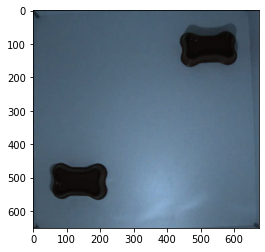

In [66]:
trial0 = 1
trial = 1

x_positions_pre_nose = tracking[:,0].T
y_positions_pre_nose = tracking[:,1].T
#x_positions = beh_func.filter_positions_mode(signal=x_positions_pre, window=2)
#y_positions = beh_func.filter_positions_mode(signal=y_positions_pre, window=2)
x_positions_inter_nose,y_positions_inter_nose  = beh_func.interpolate_positions(x_positions_pre_nose, y_positions_pre_nose)
#time = np.linspace(0, x_positions1.shape[0], num=x_positions1.shape[0], endpoint=True)
#x_interpolation = interp1d(time, x_positions1, kind = 'cubic')
#y_interpolation = interp1d(time, y_positions1, kind = 'cubic')
x_positions_nose = x_positions_inter_nose#gaussian_filter(x_positions_inter_nose, sigma=2)
y_positions_nose = y_positions_inter_nose#gaussian_filter(y_positions_inter_nose, sigma=2)

x_positions_pre_head = tracking[:,2].T
y_positions_pre_head = tracking[:,3].T
x_positions_inter_head,y_positions_inter_head  = beh_func.interpolate_positions(x_positions_pre_head, y_positions_pre_head)
#time = np.linspace(0, x_positions1.shape[0], num=x_positions1.shape[0], endpoint=True)
#x_interpolation = interp1d(time, x_positions1, kind = 'cubic')
#y_interpolation = interp1d(time, y_positions1, kind = 'cubic')
x_positions_head = x_positions_inter_head #gaussian_filter(x_positions_inter_head, sigma=2)
y_positions_head = y_positions_inter_head  #gaussian_filter(y_positions_inter_head, sigma=2)

position = np.array([x_positions_head, y_positions_head]).T
position_nose = np.array([x_positions_nose, y_positions_nose]).T
vx = np.zeros((x_positions_head.shape[0], 1))
vy = np.zeros((y_positions_head.shape[0], 1))
vx[1:,0]=np.diff(position[:,0])
vy[1:,0]=np.diff(position[:,1])
speed = np.sqrt(vx*vx+vy*vy)

## objects positions for general fideos using positional files
## initial file that conteins mouse, session, trial, resting, and timestramp information.
# This table conteins all mice info
## object positions directory
current_directory = os.environ['PROJECT_DIR'] + 'data/scoring_sheets/'
if mouse == 32363 or mouse == 32364 or mouse == 32365 or mouse == 32366:
    mice_directory = '32363-32366/'
else:
    mice_directory = '56165-56166/'

objects_file_name = current_directory + mice_directory + 'mouse_training_OS_calcium_1.xlsx'
objects_list_structure = ['condition', 'goal','group','session','drug','subject', 'trial','day', 'loc_1','loc_2']
object_list = pd.read_excel(objects_file_name)
object_list = pd.DataFrame(object_list,columns=objects_list_structure)
current_object_data = object_list[ object_list.subject ==mouse]
current_object_data = current_object_data[current_object_data.session == session]
objects = ['LR', 'LL', 'UR', 'UL']
session_trial = []
session_trial.append(np.arange(1,6))
session_trial.append(np.arange(6,11))
session_trial.append(np.arange(11,16))
session_trial.append(np.arange(16,21))
session_trial.append(np.arange(21,22))
object1 = current_object_data.iloc[session_trial[day][trial0-1] - 1]['loc_1']
object2 = current_object_data.iloc[session_trial[day][trial0-1] - 1]['loc_2']

## define coordinates of objects in pixels acording to the frame size
## and define the exploratory flag

if object1 == 'LL':
    object1_x = 550
    object1_y = 100
if object1 == 'LR':
    object1_x = 150
    object1_y = 100
if object1 == 'UR':
    object1_x = 150
    object1_y = 500
if object1 == 'UL':
    object1_x = 550
    object1_y = 500

if object2 == 'LL':
    object2_x = 550
    object2_y = 100
if object2 == 'LR':
    object2_x = 150
    object2_y = 100
if object2 == 'UR':
    object2_x = 150
    object2_y = 500
if object2 == 'UL':
    object2_x = 550
    object2_y = 500

center_coordinates1 = np.array([object1_x,object1_y])
center_coordinates2 = np.array([object2_x,object2_y])

## get points coordinates for head direction and objects location
p2 = position_nose # nose position
p1 = position # head position
p3= center_coordinates1*np.ones_like(p1)
p4 = center_coordinates2*np.ones_like(p1)

## binary looking at object vectors
looking_vector1, angle1_vector = beh_func.looking_at_vector(p2,p1,p3)
looking_vector2, angle2_vector = beh_func.looking_at_vector(p2,p1,p4)

## proximity vector between mouse position and objects
proximity_vector1 = beh_func.proximity_vector(position,p3,radius = 200)
proximity_vector2 = beh_func.proximity_vector(position,p4,radius=200)

## super proximity vector for mouse position and objects (closer that proximity1)
super_proximity_vector1 = beh_func.proximity_vector(position,p3,radius=150)
super_proximity_vector2 = beh_func.proximity_vector(position,p4,radius=150)

## select events of a certain duration
looking_vector1_last = beh_func.long_duration_events(looking_vector1,1)
looking_vector2_last = beh_func.long_duration_events(looking_vector2,1)

proximity_vector1_last = beh_func.long_duration_events(proximity_vector1,1)
proximity_vector2_last = beh_func.long_duration_events(proximity_vector2,1)

super_proximity_vector1_last = beh_func.long_duration_events(super_proximity_vector1,1)
super_proximity_vector2_last = beh_func.long_duration_events(super_proximity_vector2,1)



####################################################################################################################
# FROM HERE THE SCRIPT IS RELATED TO GENERATE THE VIDEO!
####################################################################################################################
## load input video DLC using cv2
font = cv2.FONT_HERSHEY_SIMPLEX

if not os.path.isfile(input_video_path_dlc):
    print('ERROR: File not found')
cap_dlc = cv2.VideoCapture(input_video_path_dlc)
try:
    length = int(cap_dlc.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap_dlc.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_dlc.get(cv2.CAP_PROP_FRAME_HEIGHT))
except:
    #logging.info('Roll back to opencv 2')
    length = int(cap_dlc.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
    width = int(cap_dlc.get(cv2.cv.CV_CAP_PROP_FRAME_WIDTH))
    height = int(cap_dlc.get(cv2.cv.CV_CAP_PROP_FRAME_HEIGHT))
if length == 0 or width == 0 or height == 0:  # CV failed to load
    cv_failed = True
dims_dlc = [length, height, width]
limits = False
ret, frame = cap_dlc.read()
plt.imshow(frame)

### create a new video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
#fourcc = cv2.VideoWriter_fourcc(*'DIVX')
output_video_dlc = cv2.VideoWriter(output_video_path, fourcc, 10, (width ,height))
# Radius of circle
radius = 150
radius2= 100
speed_lim = 5
## objects positions for this particular video
center_coordinates1 = (object1_x,object1_y)
center_coordinates2 = (object2_x,object2_y)
# Blue color in BGR
color1 = (255, 0, 0)
color2 = (0, 0, 255)
color3 = (0, 255, 0)
color4 = (255,255,0)

# Line thickness of 5 px
thickness = 5
pos_cero = np.array([0,0])
time = 0
while True:
    ret, frame = cap_dlc.read()
    if not ret:
        break
    value = 2
    if time % value == 0:
        interaction = ethogram_classification[int(time/value)]
        cv2.circle(frame, (int(parameters_matrix[0,int(time/value)]),int(parameters_matrix[1,int(time/value)])), 50, color2, thickness)
        if interaction == 0:
            cv2.putText(frame, 'State1', (50, 550),font, 3,color_text, 2, cv2.LINE_AA)
        if interaction == 1:
            cv2.putText(frame, 'State2', (50, 550),font, 3,color_text, 2, cv2.LINE_AA)
        if interaction == 2:
            cv2.putText(frame, 'State3', (50, 550),font, 3,color_text, 2, cv2.LINE_AA)
        if interaction == 3:
            cv2.putText(frame, 'State4', (50, 550),font, 3,color_text, 2, cv2.LINE_AA)
        if interaction == 4:
            cv2.putText(frame, 'State5', (50, 550),font, 3,color_text, 2, cv2.LINE_AA)
        if interaction == 5:
            cv2.putText(frame, 'State6', (50, 550),font, 3,color_text, 2, cv2.LINE_AA)
        if interaction == 6:
            cv2.putText(frame, 'State7', (50, 550),font, 3,color_text, 2, cv2.LINE_AA)
        if position[int(time/2),0] != -1000 and position[int(time/2),1] != -1000:
            pt1 = (int(p1[int(time / 2), 0]), int(p1[int(time / 2), 1]))
            pt2 = (int(p2[int(time / 2), 0]), int(p2[int(time / 2), 1]))
            closesness = 0
            inspection = 0
            if proximity_vector1_last[int(time/2)]:#and not math.isnan(angle1_vector[int(time/2)]):
                cv2.circle(frame,center_coordinates1,radius2,color4,thickness)
                closesness = 1
                cv2.arrowedLine(frame, pt1, pt2, color4, 5, 8)
                if looking_vector1_last[int(time/2)] or super_proximity_vector1_last[int(time/2)]:
                    cv2.putText(frame, 'ExploringObj1', (10, 450),font, 3,color4, 2, cv2.LINE_AA)
                    if super_proximity_vector1_last[int(time/2)]:
                        cv2.circle(frame, center_coordinates1, radius2, color4, thickness)
            else:
                if proximity_vector2_last[int(time/2)]:#  and not math.isnan(angle2_vector[int(time/2)]):
                    cv2.circle(frame, center_coordinates2, radius2, color4, thickness)
                    closesness = 1
                    cv2.arrowedLine(frame, pt1, pt2, color4, 5, 8)
                    if looking_vector2_last[int(time / 2)] or super_proximity_vector1[int(time/2)]:
                        cv2.putText(frame, 'ExploringObj2', (10, 450),font, 3,color4, 2, cv2.LINE_AA)
                        if super_proximity_vector2[int(time/2)]:
                            cv2.circle(frame, center_coordinates2, radius2, color4, thickness)
            if speed[int(time/2)] > speed_lim and closesness == 0:
                if looking_vector1_last[int(time/2)] and not looking_vector2_last[int(time/2)]:
                    inspection = 1
                    cv2.arrowedLine(frame, pt1, pt2, color2, 5, 8)
                    cv2.putText(frame, 'RunningTo1',(10, 450),font, 3,color2, 2, cv2.LINE_AA)
                    cv2.circle(frame, (int(position[int(time/2),0]),int(position[int(time/2),1])), radius2,
                               color2, thickness)
                if looking_vector2_last[int(time/2)] and not looking_vector1_last[int(time/2)]:
                    inspection = 1
                    cv2.arrowedLine(frame, pt1, pt2, color2, 5, 8)
                    cv2.putText(frame, 'RunningTo2', (10, 450),font, 3,color2, 2, cv2.LINE_AA)
                    cv2.circle(frame, (int(position[int(time / 2), 0]), int(position[int(time / 2), 1])),
                               radius2, color2, thickness)
                if inspection == 0:
                    cv2.arrowedLine(frame, pt1, pt2, color3, 5, 8)
                    cv2.putText(frame, 'Running', (10, 450),font, 3,color3, 3, cv2.LINE_AA)
                    cv2.circle(frame, (int(position[int(time / 2), 0]), int(position[int(time / 2), 1])),
                               radius2, color3, thickness)
            if speed[int(time/2)] < speed_lim and closesness == 0 and inspection == 0:
                    cv2.arrowedLine(frame, pt1, pt2, color1, 5, 8)
                    cv2.putText(frame, 'Resting',(10, 450),font, 3, color1, 2, cv2.LINE_AA)
                    cv2.circle(frame, (int(position[int(time / 2), 0]), int(position[int(time / 2), 1])), radius2,
                                       color1, thickness)

            cv2.waitKey(0)
    #if time > 2*20 and time % 20 == 0:
            output_video_dlc.write(frame)
    #print(time)
    time = time + 1

In [28]:
int(parameters_matrix[0,500])

613

In [31]:
coordinates1

array([550, 500])

In [45]:
parameters_matrix[1,1000]

157.708

In [ ]:
time
